# Module 3 Project

# Imports



In [1420]:
from api import key
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
import numpy as np

# API Requests 

In [648]:

url =  "https://api.eia.gov/series/?api_key=106ca842268ae4f59b5872302c603bf2&series_id=EMISS.CO2-TOTV-RC-TO-DC.A" 
response = requests.get(url)

In [768]:
DC_Transport = response.json()
DC_Transport = pd.DataFrame(DC_Transport['series'][0]['data'])
DC_Transport.columns = ['Year', 'Transport_million_metric_tons']
DC_Transport.head(2)

,Year,Transport_million_metric_tons
0,2017,0.019913
1,2016,0.031299


In [756]:
url =  "https://api.eia.gov/series/?api_key=106ca842268ae4f59b5872302c603bf2&series_id=EMISS.CO2-TOTV-IC-TO-DC.A" 
response = requests.get(url)

In [770]:
DC_Residential = response.json()
DC_Residential = pd.DataFrame(DC_Residential['series'][0]['data'])
DC_Residential.columns = ['Year', 'Residential_million_metric_tons']
DC_Residential.head(2)

,Year,Residential_million_metric_tons
0,2017,0.019913
1,2016,0.031299


In [771]:
url = 'https://api.eia.gov/series/?api_key=106ca842268ae4f59b5872302c603bf2&series_id=EMISS.CO2-TOTV-CC-TO-DC.Ahttps://api.eia.gov/series/?api_key=106ca842268ae4f59b5872302c603bf2&series_id=EMISS.CO2-TOTV-CC-TO-DC.A'
response = requests.get(url)
DC_Commercial = response.json()
DC_Commercial = pd.DataFrame(DC_Commercial['series'][0]['data'])
DC_Commercial.columns = ['Year', 'Commerical_million_metric_tons']
DC_Commercial.head(2)

,Year,Commerical_million_metric_tons
0,2017,0.942947
1,2016,0.944227


In [948]:
url = 'https://api.eia.gov/series/?api_key=106ca842268ae4f59b5872302c603bf2&series_id=EMISS.CO2-TOTV-IC-TO-DC.A'
response = requests.get(url)
DC_Industrial = response.json()  
DC_Industrial = pd.DataFrame(DC_Industrial['series'][0]['data'])
DC_Industrial.columns = ['Year', 'Industrial_million_metric_tons']
DC_Industrial.head(2)


,Year,Industrial_million_metric_tons
0,2017,0.019913
1,2016,0.031299


In [950]:
Combined_1 = DC_Commercial.merge(DC_Industrial, on= 'Year')

In [951]:
sectors = [DC_Industrial, DC_Residential, DC_Transport]

In [952]:
Combined_1 = DC_Commercial
for rock in sectors:
    Combined_1 = Combined_1.merge(rock, on= 'Year')
    
    

In [953]:
Combined_1.head()

,Year,Commerical_million_metric_tons,Industrial_million_metric_tons,Residential_million_metric_tons,Transport_million_metric_tons
0,2017,0.942947,0.019913,0.019913,0.019913
1,2016,0.944227,0.031299,0.031299,0.031299
2,2015,1.027503,0.022500,0.022500,0.022500
3,2014,1.017397,0.026327,0.026327,0.026327
4,2013,0.992099,0.020866,0.020866,0.020866


In [680]:
Combined_1['CO2 Commerical (million metric tons)'].sum()

48.677766000000005

In [1004]:
_STATES =  {'Alabama' : 'AL',
'Alaska' : 'AK',
'Arizona' : 'AZ',
'Arkansas' : 'AR',
'California' : 'CA',
'Colorado' : 'CO',
'Connecticut' : 'CT',
'Delaware' : 'DE',
'Florida' : 'FL',
'Georgia' : 'GA',
'Hawaii' : 'HI',
'Idaho' : 'ID',
'Illinois' : 'IL',
'Indiana' : 'IN',
'Iowa' : 'IA',
'Kansas' : 'KS',
'Kentucky' : 'KY',
'Louisiana' : 'LA',
'Maine' : 'ME',
'Maryland' : 'MD',
'Massachusetts' : 'MA',
'Michigan' : 'MI',
'Minnesota' : 'MN',
'Mississippi' : 'MS',
'Missouri' : 'MO',
'Montana' : 'MT',
'Nebraska' : 'NE',
'Nevada' : 'NV',
'New Hampshire' : 'NH',
'New Jersey' : 'NJ',
'New Mexico' : 'NM',
'New York' : 'NY',
'North Carolina' : 'NC',
'North Dakota' : 'ND',
'Ohio' : 'OH',
'Oklahoma' : 'OK',
'Oregon' : 'OR',
'Pennsylvania' : 'PA',
'Rhode Island' : 'RI',
'South Carolina' : 'SC',
'South Dakota' : 'SD',
'Tennessee' : 'TN',
'Texas' : 'TX',
'Utah' : 'UT',
'Vermont' : 'VT',
'Virginia' : 'VA',
'Washington' : 'WA',
'West Virginia' : 'WV',
'Wisconsin' : 'WI',
'Wyoming' : 'WY'
}

In [1005]:
_STATES.values()

dict_values(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])

In [1006]:
url =  "https://api.eia.gov/series" 

PARMS = {'api_key':'106ca842268ae4f59b5872302c603bf2',
         'series_id': 'EMISS.CO2-TOTV-TT-TO-DC.A' 
        }

data = []


#Initialize an empty dataframe to begin
df = pd.DataFrame()

# Call the api multiple times for each state
for state in _STATES.values():
    
    # Reconstruct the series_id string to reflect the state
    PARMS['series_id'] = PARMS['series_id'][:21] + state + '.A'  
    response = requests.get(url, params=PARMS)
    data.append(response)
    

# Iterate through all the responses saved in the list called 'data'
for tmp in data:
    
    #Save the dataframe to a temporary spot called '_'
    _ = pd.DataFrame(tmp.json()['series'][0]['data'], columns = ['Year', 'Carbon_Emissions'])
                     
    # Create a third column called 'State' and set the defualt value to the name of the state                 
    _['State'] = tmp.json()['series'][0]['name'].split(', ')[2]
                     
    #update our main dataframe with additional rows
    df = pd.concat([df, _]) 

In [978]:
df.head()

,Year,Carbon_Emissions,State
0,2017,109.018634,Alabama
1,2016,114.872696,Alabama
2,2015,120.012608,Alabama
3,2014,123.080771,Alabama
4,2013,120.732885,Alabama


In [1144]:
grouped = df.groupby('State')
grouped = pd.DataFrame(grouped.sum())
grouped.reset_index(inplace=True)

grouped.sort_values(by='Carbon_Emissions', ascending=False, inplace=True)
grouped.shape

(50, 2)

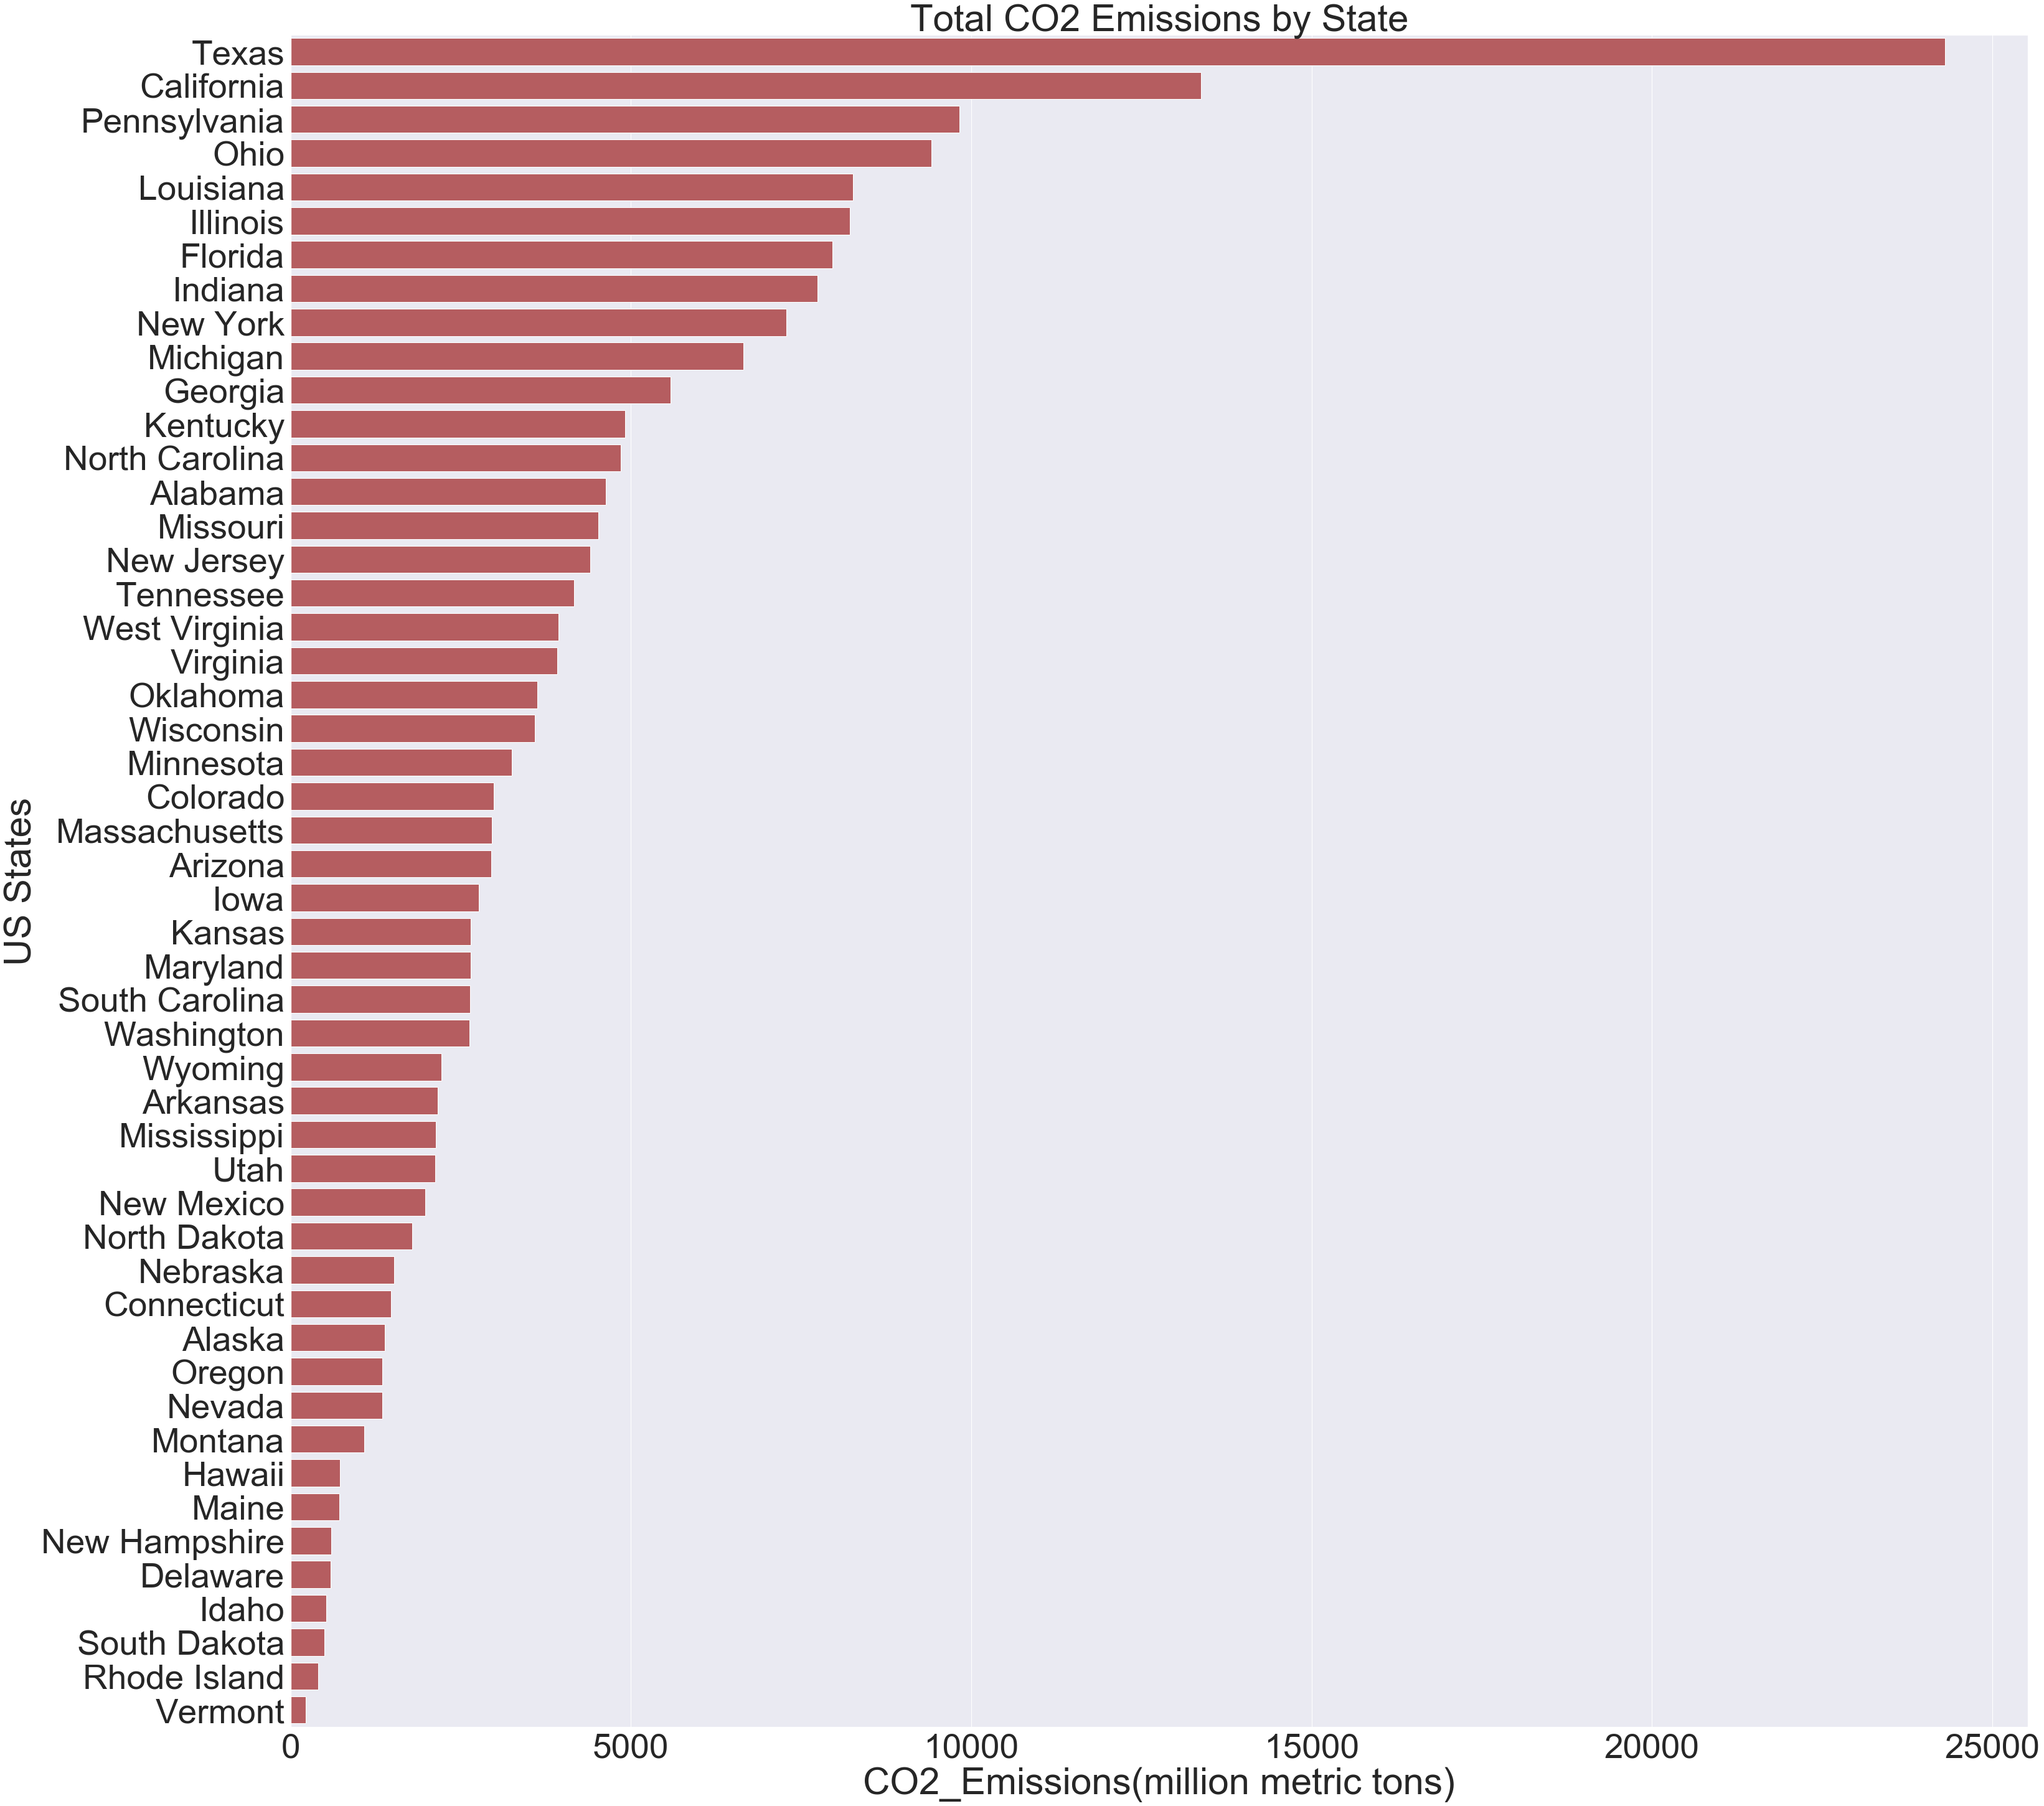

In [1009]:
plt.figure(figsize=(50, 50))
sns.barplot(grouped.Carbon_Emissions, grouped.State, color='r')
plt.xlabel('CO2_Emissions(million metric tons)')
plt.ylabel('US States')
plt.title('Total CO2 Emissions by State')
sns.set(context='notebook',
        style='darkgrid',
        palette='deep',
        font='sans-serif',
        font_scale=5)


In [986]:
grouped['Region'] = None


In [1359]:

              
North_East = [ 'New Jersey', 'New York','Connecticut', 'Rhode Island', 'Massachusetts',
              'New Hampshire', 'Maine', 'Vermont', 'Pennsylvania']


Mid_West  = ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota',
            'Missouri', 'Iowa','Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio' ]


West = ['California', 'Alaska', 'Washington', 'Oregon', 'Nevada', 
                  'Idaho', 'Utah', 'Montana', 'Wyoming', 'Colorado', 
                  'Hawaii', 'New Mexico', 'Arizona']

South = ['Texas', 'oklahoma', 'North Carolina','Arkansas', 'Alabama', 'Delaware',
        'Virginia', 'Florida', 'West Virginia', 'South Carolina', 'Louisiana', 'Georgia', 'Louisiana', 
         'Mississippi', 'Tennessee','Kentucky', 'Maryland' ]


# link to NGO https://www.nationalgeographic.org/maps/united-states-regions/

In [1360]:
def region_maker(state):
    if state in West:
        return 'West'
    if state in South:
        return 'South'
    if state in Mid_West:
        return 'Mid_West'
    if state in North_East:
        return 'North_East'
    
    
grouped['Region'] = grouped.State.apply(region_maker)
grouped.Carbon_Emissions.describe()

count       50.000000
mean      4028.287053
std       4105.222559
min        221.872472
25%       1486.955987
50%       2854.111233
75%       4798.352589
max      24307.492673
Name: Carbon_Emissions, dtype: float64

In [1361]:
#SAMPLE STATISTICS

East = grouped.loc[grouped['Region'] == 'South']
East.Carbon_Emissions.describe()


count       15.000000
mean      5512.524600
std       5597.021462
min        587.754142
25%       2642.098480
50%       4159.759473
75%       5249.662395
max      24307.492673
Name: Carbon_Emissions, dtype: float64

In [1159]:
#Z SCORE

x_bar = 5512.52 # sample mean 
n =  17 # number of students
sigma = 4105.22 # sd of population
mu = 4028.28 # Population mean 

z = (x_bar - mu)/(sigma/sqrt(n))


z 


1.4907065379606348

In [1160]:
#z VALUE

stats.norm.cdf(z)

0.9319807205858027

In [1161]:
# P value

pval = 1 - stats.norm.cdf(z)
pval

0.06801927941419728

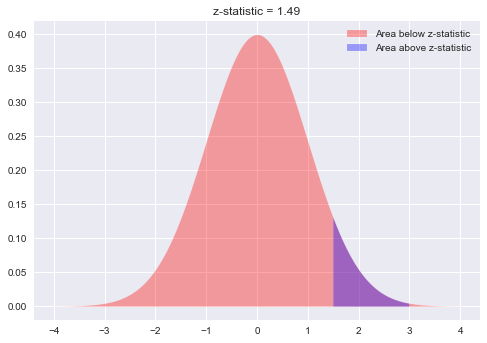

In [1162]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.fill_between(x=np.arange(-4,4,0.01),
                 y1= stats.norm.pdf(np.arange(-4,4,0.01)) ,
                 facecolor='red',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(1.49,3,0.01), 
                 y1= stats.norm.pdf(np.arange(1.49,3,0.01)) ,
                 facecolor='blue',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = 1.49');

# One sample Z test 

Null hypothesis = CO2 emissions from the West coast region is the same as the state 

Hypothesis = There is a differnce between the state and the West Coast

In [1362]:
by_region = grouped.groupby(grouped.Region)
by_region = (by_region.sum())
by_region.reset_index(inplace=True)

by_region

,Region,Carbon_Emissions
0,Mid_West,52578.690083
1,North_East,27870.109303
2,South,82687.868993
3,West,34654.963282


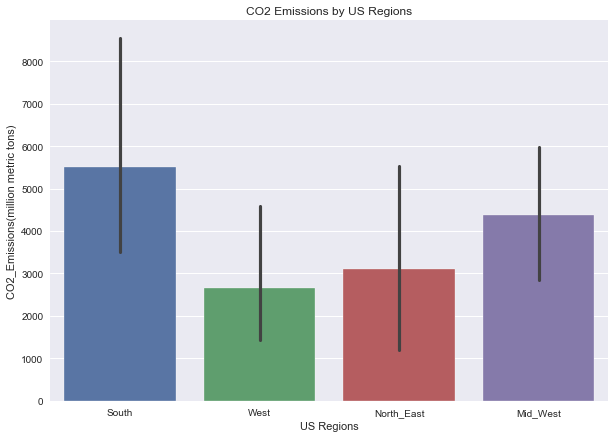

In [1363]:
plt.figure(figsize=(10, 7))
sns.barplot(grouped.Region, grouped.Carbon_Emissions)
plt.ylabel('CO2_Emissions(million metric tons)')
plt.xlabel('US Regions')
plt.title('CO2 Emissions by US Regions')
sns.set(context='notebook',
        style='darkgrid',
        palette='deep',
        font='sans-serif',
        font_scale=0)


# Population Data obtained from the US Census Bureau

link = https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/

In [860]:
pop = pd.read_csv('/Users/lidetalemu/Documents/SCPRC-EST2019-18+POP-RES.csv')

In [1366]:
popn = pop.drop(0)

popn.head(2)

popn.sort_values(by='POPESTIMATE2019', ascending=False, inplace=True)
popn.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS
5,40,4,9,6,California,39512223,30617582,77.5
44,40,3,7,48,Texas,28995881,21596071,74.5
10,40,3,5,12,Florida,21477737,17247808,80.3
33,40,1,2,36,New York,19453561,15425262,79.3
39,40,1,2,42,Pennsylvania,12801989,10167376,79.4


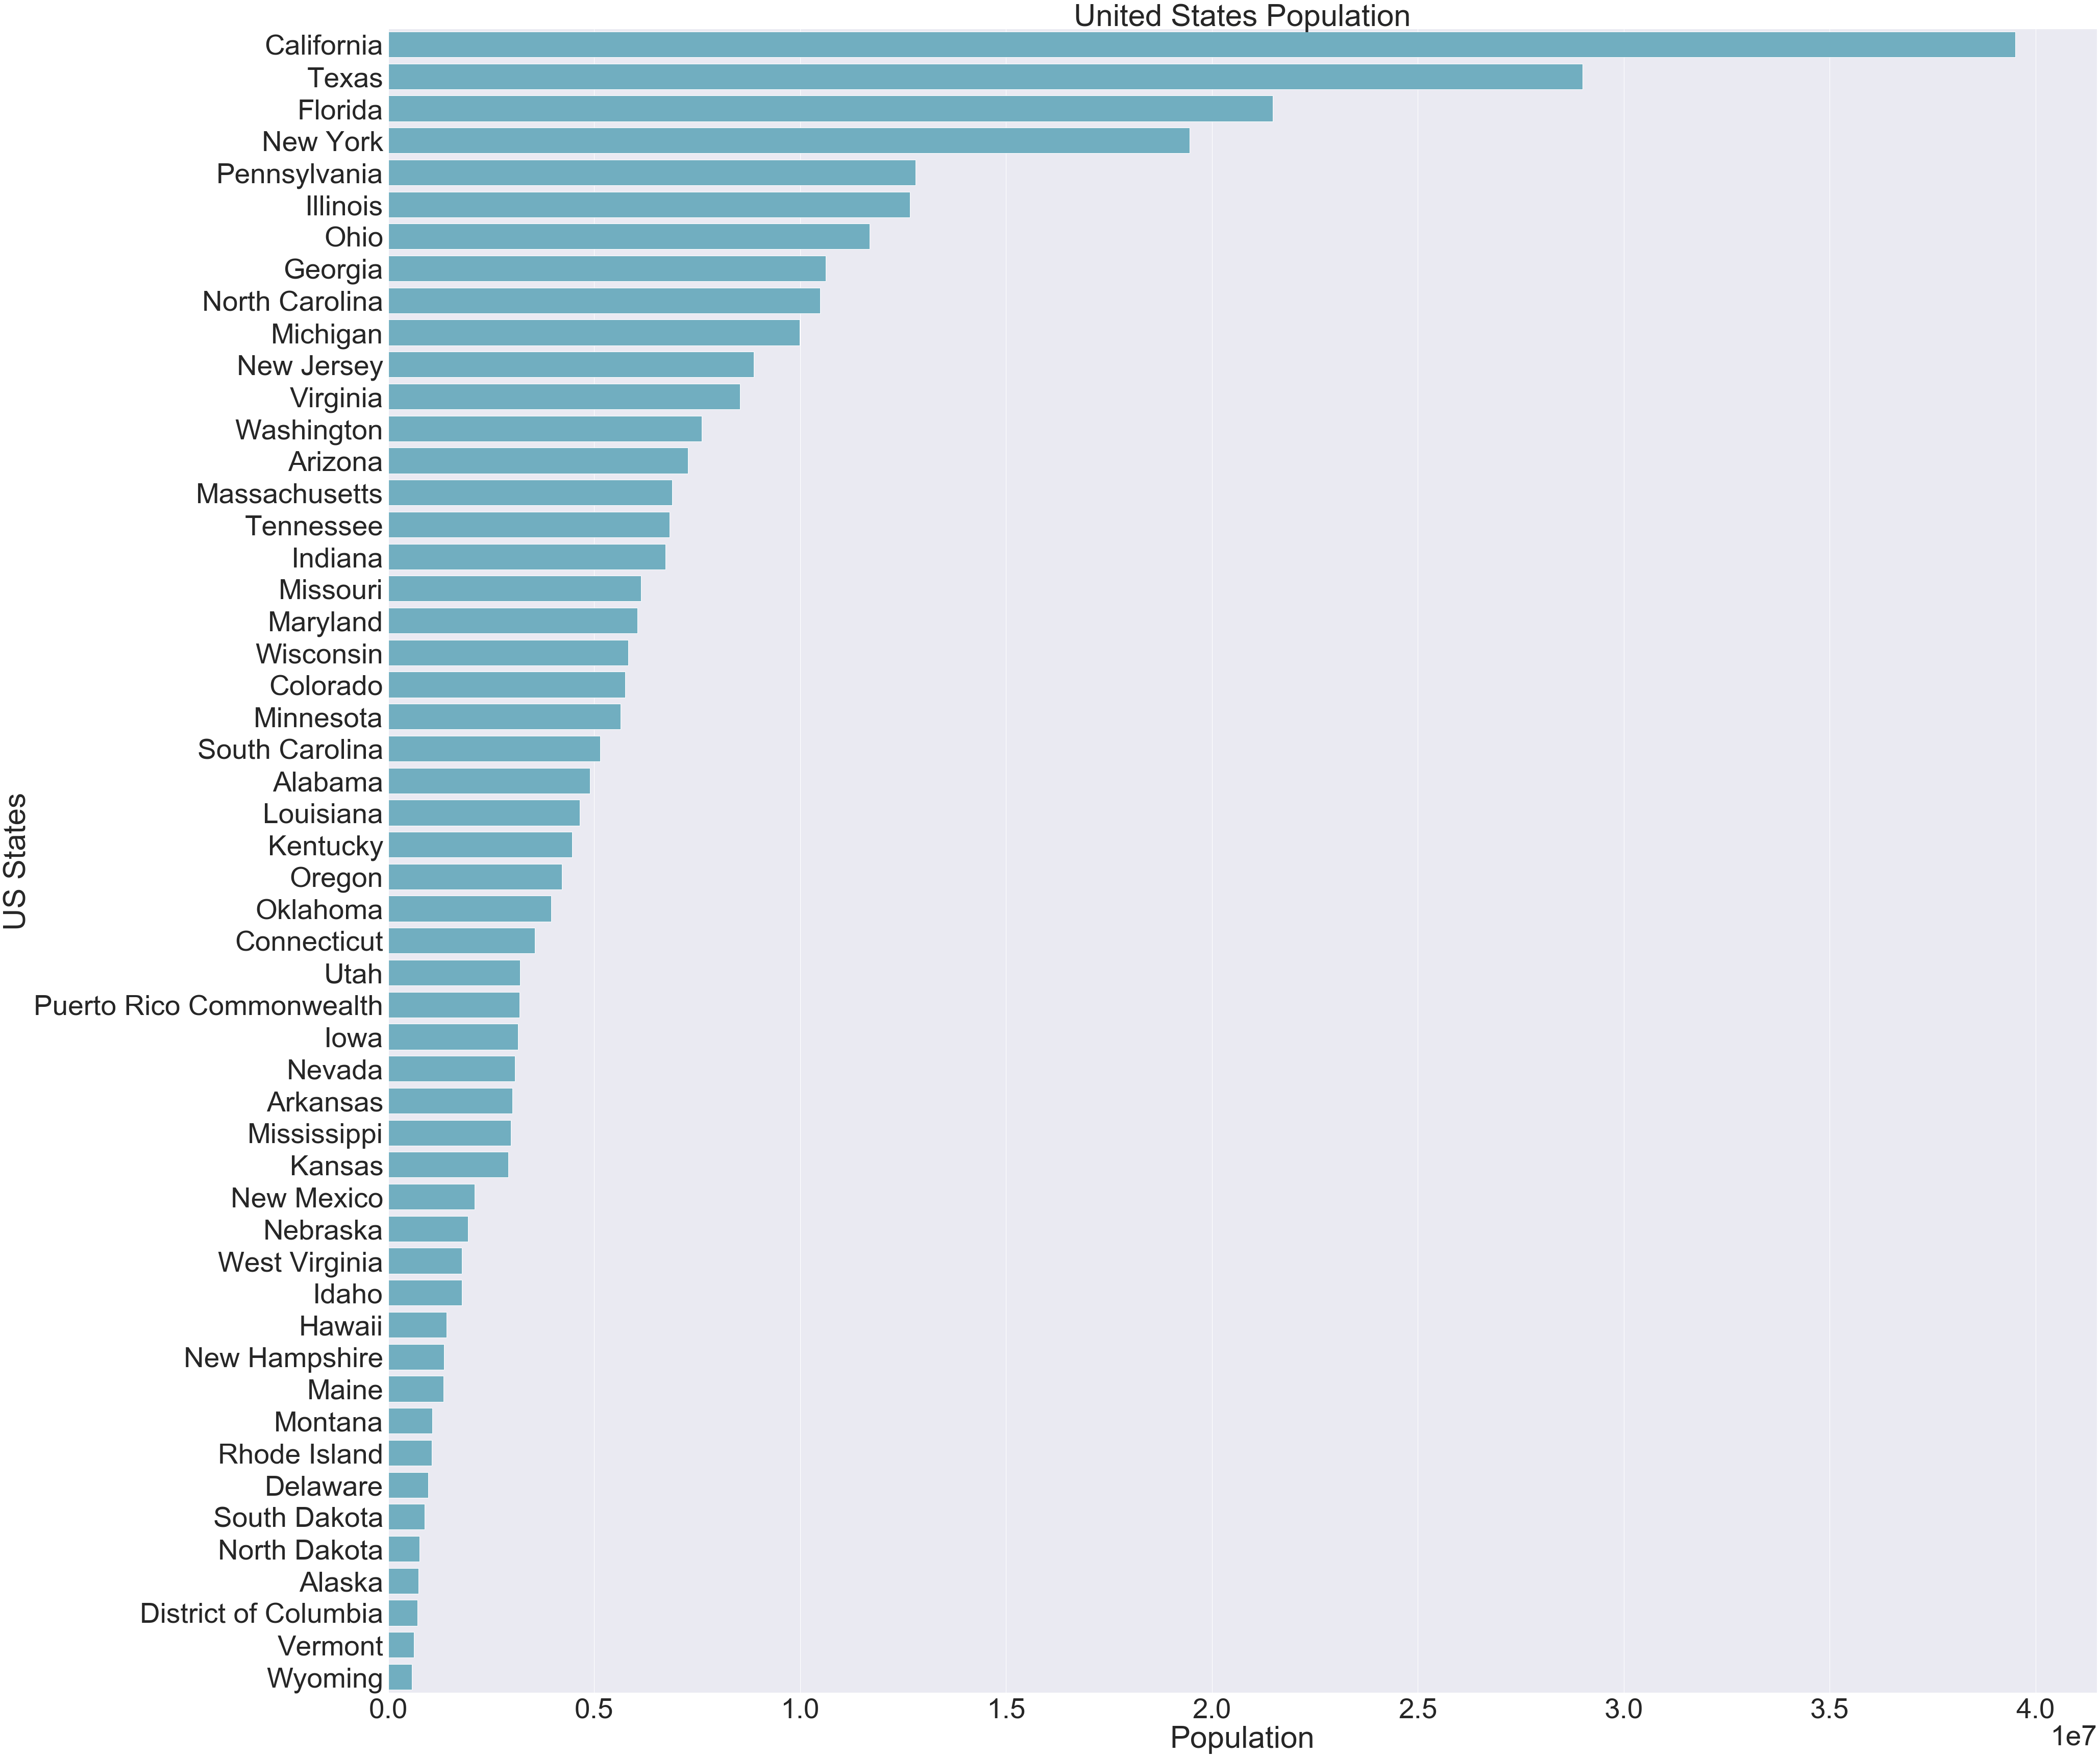

In [880]:
plt.figure(figsize=(60, 60))
sns.barplot(popn.POPESTIMATE2019, popn.NAME, color='c')
plt.xlabel('Population')
plt.ylabel('US States')
plt.title('United States Population')
sns.set(context='notebook',
        style='darkgrid',
        palette='deep',
        font='sans-serif',
        font_scale=5)


In [ ]:
sample_mean = 

In [1367]:
x_bar = 103 # sample mean 
n = 40 # number of students
sigma = 16 # sd of population
mu = 100 # Population mean 

z = (x_bar - mu)/(sigma/sqrt(n))
z

1.1858541225631423

In [1368]:
population_df = pd.read_excel('/Users/lidetalemu/Downloads/nst-est2019-01.xlsx')


In [1369]:
population_df.columns = population_df.iloc[2]

population_df.rename(columns = {np.nan: 'States',         
                                'Census': 'Census', 
                                'Estimates Base': 'Estimates Base',             
                                2010 : 2010,
                                2011.0 : 2011,
                                2012.0 : 2012,
                                2013.0 : 2013,
                                2014.0 : 2014,
                                2015.0 : 2015,           
                                2016.0 : 2016,           
                                2017.0 : 2017,           
                                2018.0 : 2018,
                                2019.0 : 2019 
                               }, 
                     inplace=True)

population_df.drop(range(3), inplace=True)

population_df.drop(list(range(59, 66)), inplace=True)

population_df['States'] = population_df['States'].map(lambda x: x.replace('.', ''))

population_df = population_df.T

population_df.columns = population_df.iloc[0]

population_df.reset_index(inplace = True)

population_df.rename(columns = {2: 'Year'}, inplace =True)

population_df.drop(range(3), inplace = True)

population_df.reset_index(inplace = True)

population_df.drop(columns=['index'], inplace=True)

population_df.index.name = None

population_df.columns = population_df.columns.get_level_values(0)



In [1370]:

population_2017 = population_df.loc[population_df['Year']== 2017]
population_2017= population_2017.T
population_2017.reset_index(inplace=True)
population_2017.columns = ['States', 'Population_Data']
population_2017.drop(0, inplace=True)

Popn_Regions = population_2017.iloc[:5]
Popn_Regions.drop(1, inplace=True)



/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1371]:
#First, you divide 38 by 230, then multiply that total by 100.

total_pop = sum(Popn_Regions.Population_Data)
Popn_Regions.Population_Data = Popn_Regions['Population_Data'].apply(lambda x: x/total_pop)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [1372]:
Popn_Regions.Population_Data = Popn_Regions.Population_Data.round(2)
Popn_Regions

,States,Population_Data
2,Northeast,0.17
3,Midwest,0.21
4,South,0.38
5,West,0.24


In [1422]:


total_emissions = sum(by_region.Carbon_Emissions)
by_region.Carbon_Emissions = by_region.Carbon_Emissions.apply(lambda x:x/total_emissions)
by_region.Carbon_Emissions = by_region.Carbon_Emissions.round(2)
by_region

,Region,Carbon_Emissions
0,Mid_West,0.27
1,North_East,0.14
2,South,0.42
3,West,0.18


In [1423]:
o = [0.27, 0.14, 0.42, 0.18]
e = [0.17, 0.21, 0.38, 0.24]



In [1433]:
chi = (o[0]-e[0])**2/e[0] + (o[1]-e[1])**2/e[1] + (o[2]-e[2])**2/e[2]
chi

0.0863673890608875

In [1428]:
#pval = 1 - stats.norm.ppf(chi)
#pval